# Index Funds with Mixed-Integer-Programming

We will analyze daily price data for stocks in the Dow Jones index and then try to build an accurate index fund using a small numbers of stocks therein.

Similar material was already used in a presentation at PyData Berlin 2017. See the ["Tour of popular packages" notebook](http://nbviewer.jupyter.org/github/daveh19/pydataberlin2017/blob/master/notebooks/02%20Tour%20of%20popular%20packages.ipynb). Back then, we worked with Julia 0.6 and used the packages `DataFrames`, `Plots` and `JuMP`. Now, we work with Julia 1.0 and use packages from the `Queryverse` and `IndexedTables` for data prep and visualization.

## Loading the Data

In [1]:
using Queryverse
using IndexedTables: ndsparse

In [2]:
price = load("dowjones2016.csv") |> ndsparse
price |> @take(3)

date,symbol,price
2016-01-04,"""AAPL""",105.35
2016-01-04,"""AXP""",67.59
2016-01-04,"""BA""",140.5


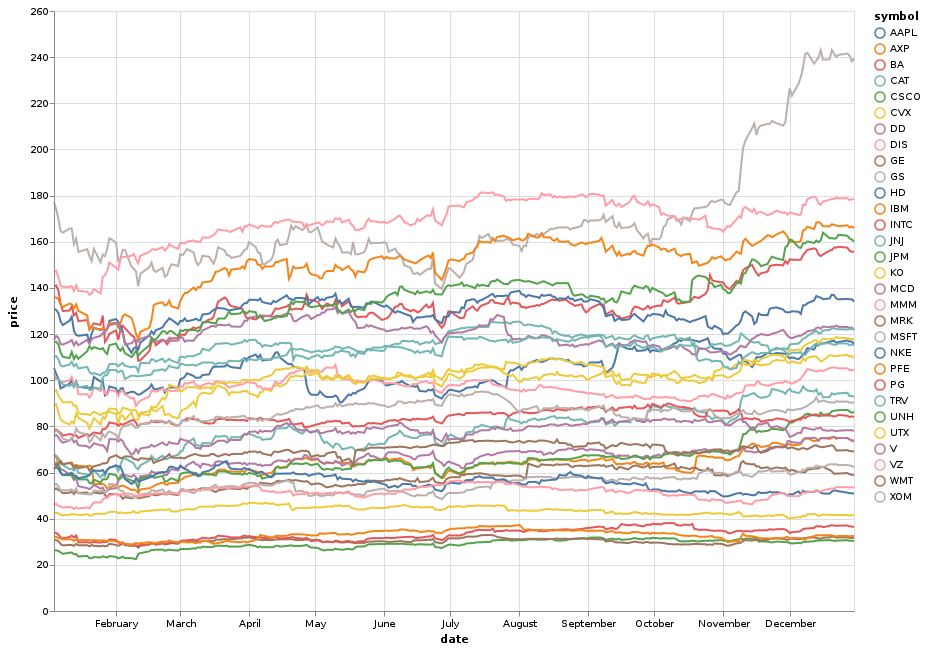

In [3]:
price |> @vlplot(:line, x=:date, y=:price, color=:symbol, width=800, height=600)

## Computing the Dow Jones Index

The Dow Jones index is computed from the prices of some 30 stocks, as a weighted average, where the weight is itself defined through the price of the stock.

We will compute the average price of each stock over the days of the year 2016. Then we will normalize these values by dividing through the total of the average prices. The normalized weights are then multiplied to the daily prices to get the daily value of the index.

In [4]:
using Statistics: mean

In [5]:
avg_price = price |>
    @groupby(_.symbol) |>
    @map({symbol=first(_.symbol), avg_price=mean(_.price)})
avg_price |> @take(4)

symbol,avg_price
"""AAPL""",104.604
"""AXP""",63.7933
"""BA""",133.112
"""CAT""",78.698


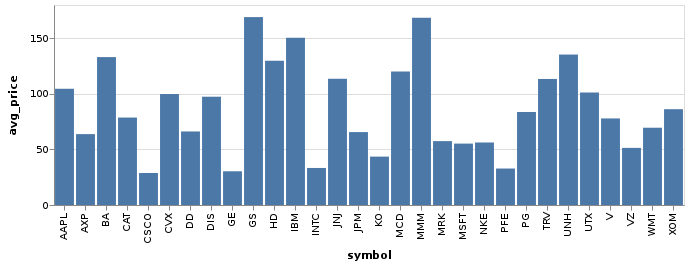

In [6]:
avg_price |> @vlplot(:bar, x=:symbol, y=:avg_price)

In [7]:
total_avg = avg_price |> @map(_.avg_price) |> sum

2617.739246769842

In [8]:
weight = avg_price |> @map({symbol=_.symbol, weight=_.avg_price / total_avg}) |> ndsparse
weight |> @take(4)

symbol,weight
"""AAPL""",0.0399597
"""AXP""",0.0243696
"""BA""",0.0508498
"""CAT""",0.0300634


In [9]:
dow_jones = price |> 
    @join(weight, _.symbol, _.symbol, {_.date, _.symbol, contrib=_.price * __.weight}) |>
    @groupby(_.date) |>
    @map({date=first(_.date), value=sum(_.contrib)})
dow_jones |> @take(4)

date,value
2016-01-04,100.573
2016-01-05,100.511
2016-01-06,99.0142
2016-01-07,96.606


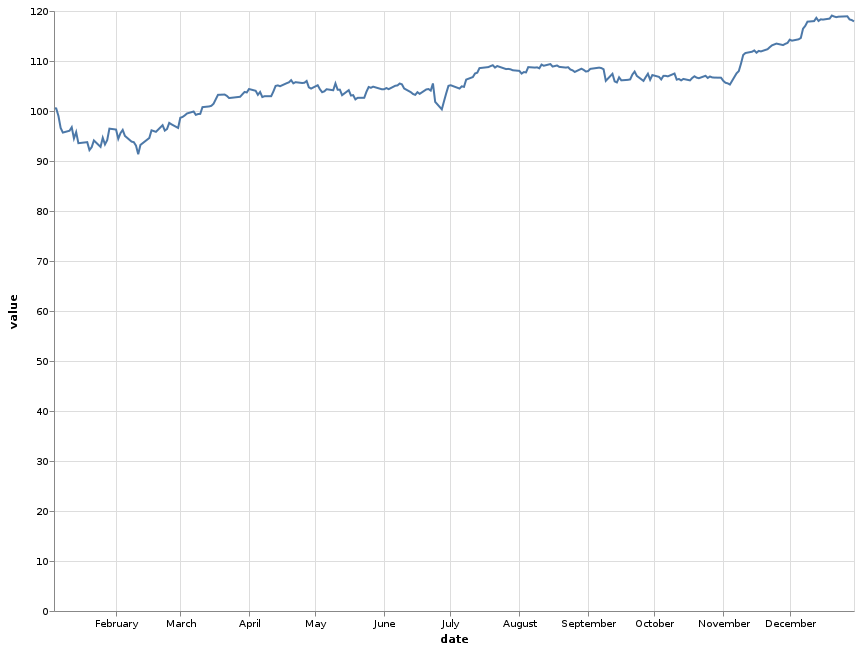

In [10]:
#price |> @vlplot(:line, x=:date, y=:price, color=:symbol, width=800, height=600)
dow_jones |> @vlplot(:line, x=:date, y=:value, width=800, height=600)

## Cross-correlation

Let's also analyze the cross-correlation between the different stocks.

In [11]:
shifted_price = price |>
    @join(avg_price, _.symbol, _.symbol, {_.date, _.symbol, shifted=_.price - __.avg_price})
shifted_price |> @take(4)

date,symbol,shifted
2016-01-04,"""AAPL""",0.74599
2016-01-04,"""AXP""",3.79666
2016-01-04,"""BA""",7.38849
2016-01-04,"""CAT""",-10.708


In [12]:
stdev = shifted_price |>
    @map({_.symbol, sqr=_.shifted^2}) |>
    @groupby(_.symbol) |>
    @map({symbol=first(_.symbol), stdev=sqrt(sum(_.sqr) / (length(_)-1))})
stdev |> @take(4)

symbol,stdev
"""AAPL""",7.64074
"""AXP""",5.21597
"""BA""",9.89409
"""CAT""",9.56996


In [13]:
covariance = shifted_price |>
    @join(shifted_price, _.date, _.date,
          {_.date, left=_.symbol, right=__.symbol, prod=_.shifted * __.shifted}) |>
    @groupby({_.left, _.right}) |>
    @map({left=first(_.left), right=first(_.right), cov=mean(_.prod)})
covariance |> @take(4)

left,right,cov
"""AAPL""","""AAPL""",58.1493
"""AAPL""","""AXP""",21.2441
"""AAPL""","""BA""",45.4184
"""AAPL""","""CAT""",55.5429


In [14]:
correlation = covariance |>
    @join(stdev, _.left, _.symbol, {_.left, _.right, _.cov, left_stdev=__.stdev}) |>
    @join(stdev, _.right, _.symbol, {_.left, _.right, cor=_.cov /(_.left_stdev * __.stdev)}) |>
    @map({_.left, _.right, _.cor, abscor=abs(_.cor)})
correlation |> @take(4)

left,right,cor,abscor
"""AAPL""","""AAPL""",0.996032,0.996032
"""AAPL""","""AXP""",0.533051,0.533051
"""AAPL""","""BA""",0.600787,0.600787
"""AAPL""","""CAT""",0.759596,0.759596


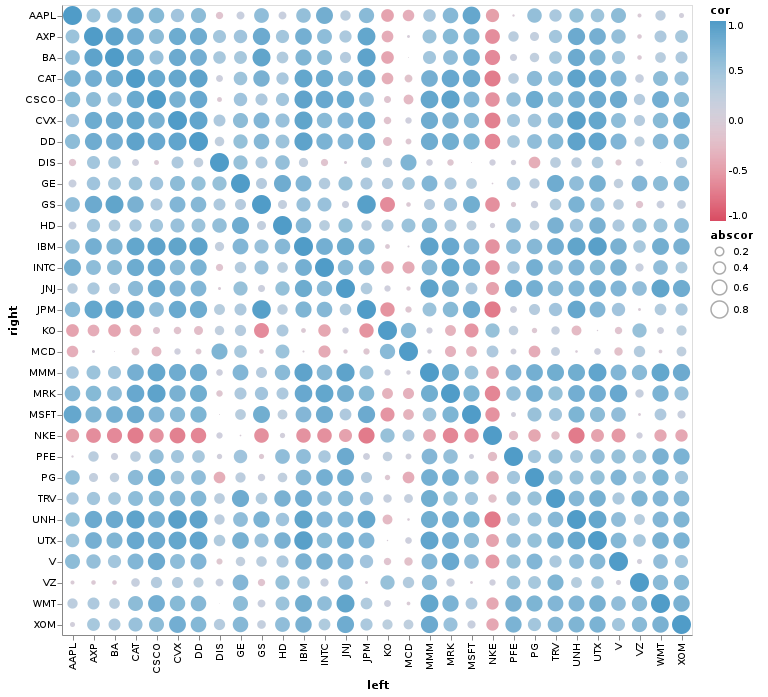

In [15]:
correlation |> @vlplot(:circle, x=:left, y=:right, size=:abscor,
                       color={"cor:q", scale={domain= [-1, 0, 1], range=["#ca0020","#f7f7f7","#0571b0"]}})